# Intro to Data Science
Data Science is an interdisciplinary field that ultimately aims to extract useful information from either structured, semi-structured or unstructured data using methods and approaches from various fields such as Statistics and Computer Science.

This notebook is an introduction to data science concepts. It is rather long, but I did my best to cover most steps in data science workflow. Based on what you are analyzing, specifics change but the general process usually remains the same. Main steps in data science process are as follows:

- Data extraction/acquisition
- Data transformation
- Data loading
- Data preprocessing
- Exploratory Analysis
- Modeling
- Validation
- Prediction
- Reporting

All steps are repeated as much as needed. In most cases, there won't be a perfect outcome of any of those steps, as the data scientist you will need to determine the cutoff point.

For the purposes of this meetup, I won't go into detail of how I performed the ETL (Extract/Transform/Load) processes because they take too long as we will be using a custom dataset. 

This notebook includes errors on purpose, so make sure you need the texts relevant to code chunks/results. The reason I included errors is that, I feel like we need to discuss errors more than we discuss successes in order to improve. Data science process is prone to errors as it is iterative so it is best to know in advance what errors you might be making. At least some of them.

This notebook holds two different analyses. The first analysis aims to predict the tournament placement of a player. While the teams are the ones that obtain placements in Dota 2 tournaments, I chose to perform my analysis in terms of players for reasons I will explain later.

The second one is the prediction of player invites for Valve tournaments by using their performance data from previous Valve tournaments. Again, teams are the ones who are invited to tournaments. But in this case, Valve specifically said that they make their invite decisions based on players so the design choice for this model actually has a basis in business strategy of Valve.

First thing we'll do is, load the dataset I prepared. The dataset is a gaming dataset, as I identify as a gamer and the data belongs to my favorite game's tournament results: Dota 2. I pulled this data from stats websites [Dotabuff](http://www.dotabuff.com/) and [Yasp](http://yasp.co). If you are interested in the data they provide, go check them out. They were instrumental in collecting this data.

The data itself consists of tournament performances of players, their tournament placements and whether they were invited to next Valve tournament or not.

The initial dataset consists of following features with corresponding data types, but we will generate some more features as well:

- Player: The Username of the player (Type: Character)
- Team: The name of the team the player's playing for
- Wins: Wins in that tournament
- Losses: Losses in that tournament
- KDA: Kill/Death/Assist Score
- Kill: Average kills
- Death: Average deaths
- Assists: Average assists
- LH: Last hits
- DN: Denies
- GPM: Average Gold per minute
- XPM: Average Experience per minute
- Position: Position of the player
- Inv_Status: Whether the player was invited to tournament
- Region: Which region the player plays in (EU/NA/SEA/CN)
- Tournament_Result: Tournament placement result
- Changed_teams: Whether the player changed teams prior to tournament
- Total_Games: Total games played in that tournament
- Outcome: Whether the player was invited to the next tournament

## Data Preprocessing and Exploratory Analysis
These two usually go hand in hand. Exploratory analysis allows data scientists to decide which preprocessing techniques to use and data preprocessing clears things further so exploratory data analysis yields better results.

In [60]:
# Load required packages. If you don't have them you need to install them using install.packages("package_name")
library(dplyr)
library(ggplot2)
library(corrgram, lib.loc="C:/Program Files/R/R-3.2.2/library")
library(caret, lib.loc="C:/Program Files/R/R-3.2.2/library")
library(gbm, lib.loc="C:/Program Files/R/R-3.2.2/library")
library(e1071, lib.loc="C:/Program Files/R/R-3.2.2/library")

In [7]:
# Load data
frankfurt <- read.csv('frankfurt_final.csv')
shanghai <- read.csv('shanghai_final.csv')
manila <- read.csv('manila_final.csv')

First exploratory analysis we'll do is to see whether there is a difference between farm(GPM/XMP) distributions between regions and positions. There is no specific reason for that, as the name suggests we are just exploring now.

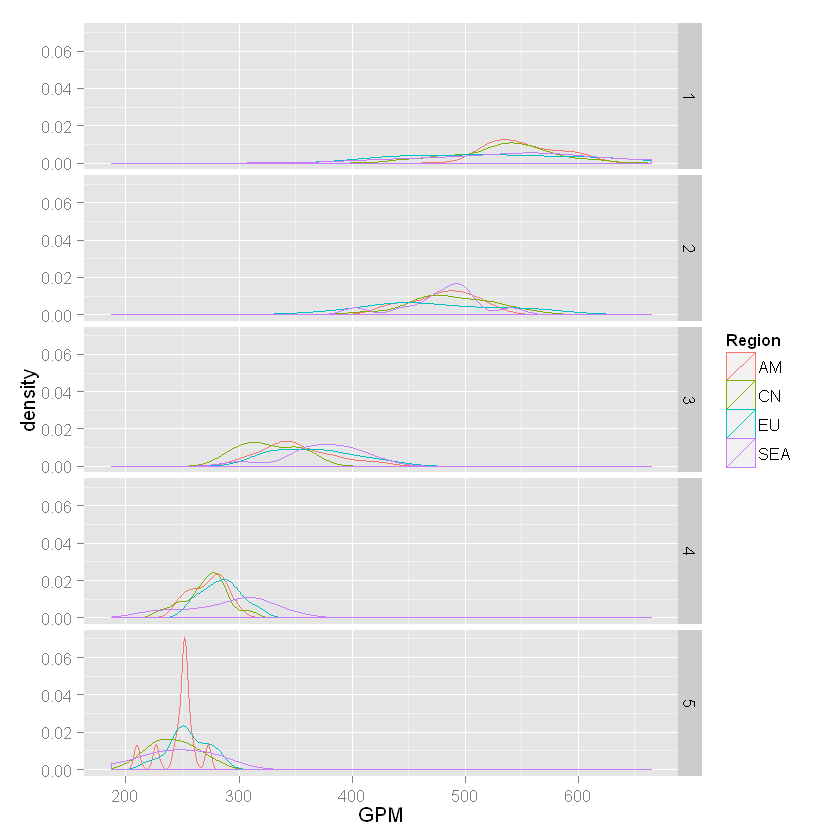

In [8]:
# Visualization
# Density plot to see farm distribution between regions and positions
g <- ggplot(data = frankfurt, aes(x = GPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

To generate this plot, we are using a package called 'ggplot2'. That is a really neat library that allows you to build various different plots with the same syntax. GG stands for "Grammar of Graphics" in this case (not "good game"). It uses a certain syntax to build a layered plot. First you generate a canvas by telling the library which data and aesthetics you will use and then tell it to put a specific plot on that canvas. If you have any other options (such as the facet_grid) you add that later.

In this case, there seems to be a significant difference in farm based on player positions. This is expected because players positions are in fact given after farm priority. Position 1 has the most farm priority while the position 5 has the least. When it comes to regions, while the shapes of distributions are different, there doesn't seem to be much difference in terms of farm based on regions except for Pos. 3 players. Pos 3 plot has some difference between regions, but we can't tell if this is significant or not by looking at this plot. However this plot just gave us something interestng to look into and this is the whole point of exploratory analysis: to find interesting quirks in data.

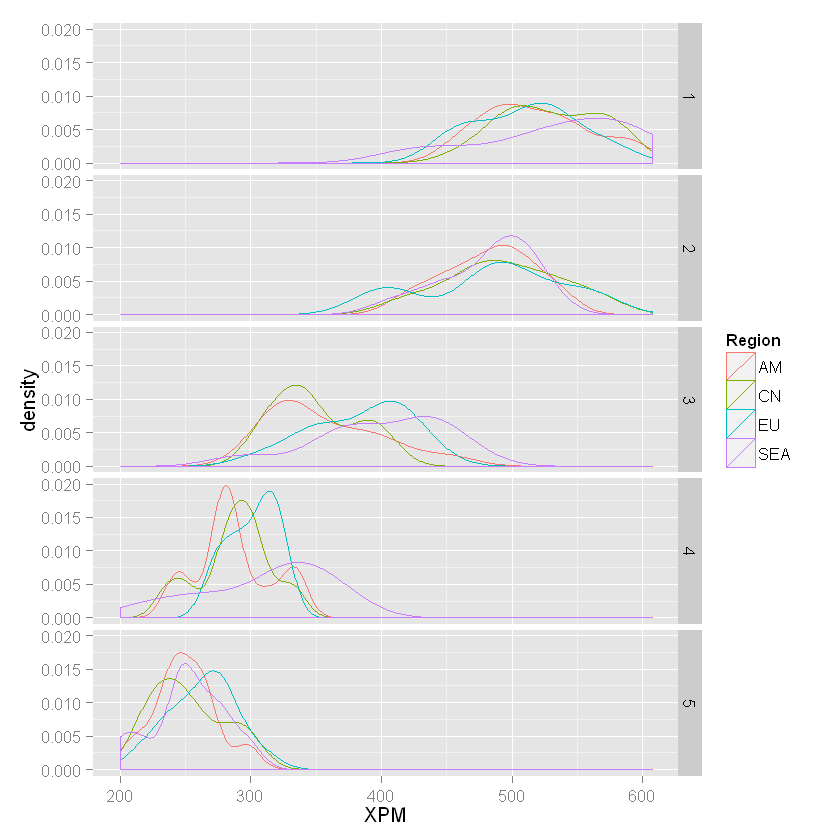

In [9]:
# Density plot to see exp distribution between regions and positions
g <- ggplot(data = frankfurt, aes(x = XPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

Again, EXP plots tell a similar story. I won't further talk about this.

The problem with the plots above is scaling. There is so much empty space, our actual plots are minimized. We can solve this by scaling the data. As you can see, the plots directed us towards a preprocessing method which we will apply shortly. But first, we need to define specific functions for our case because we don't want to lose the position's effect on farm distribution. We don't want to scale pos 1 data and pos 5 data together, we want to scale each group separately.

In [10]:
# Doesn't really tell us much because of graphical scaling, let's apply actual scaling
# We want to see if there are any differences based on region, so we scale based on the Positions
XGPM_scale <- function(x){
  x$GPM <- as.vector(scale(x$GPM))
  x$XPM <- as.vector(scale(x$XPM))
  return(x)
}

fix_dataframes <- function(x){
  x_scaled <- split(x, as.factor(x$Position))
  x_scaled <- lapply(x_scaled, XGPM_scale)
  x_scaled <- rbind(x_scaled[[1]], x_scaled[[2]], 
                    x_scaled[[3]], x_scaled[[4]], x_scaled[[5]])
  x_scaled <- arrange(x_scaled, Team, Position)
  return(x_scaled)
}

Now that we defined out functions, we can scale our sample data (Frankfurt Major).

In [12]:
scaled_frankfurt <- fix_dataframes(frankfurt)

Let's re-do the plots:

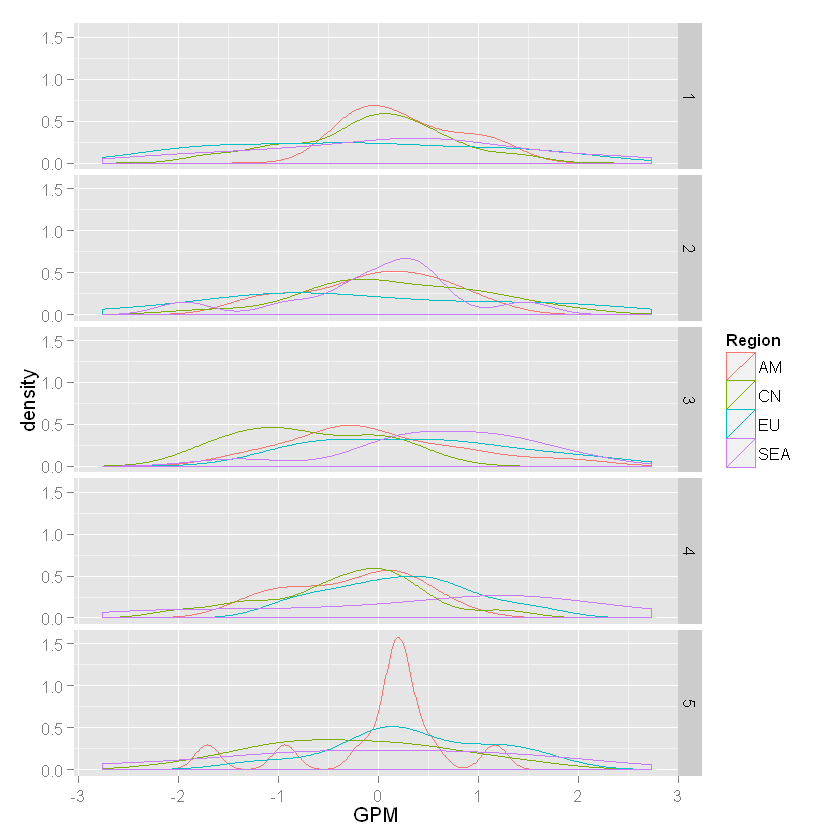

In [13]:
# Density plot to see farm distribution between regions and positions
g <- ggplot(data = scaled_frankfurt, aes(x = GPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

Now the position 3 difference is really apperant. There is no way of knowing why this happens by looking at this plot or this data. This is one thing data science cannot do on its own. It can give you interesting results. But unless you have further data to explore as to why it might be or you have the required domain expertise, there is no way of knowing why something comes up. This is why domain expertise is important. We work with people who have first hand experience in whatever field we are analyzing at so that we can reach relaible conclusions. Even Microsoft does that, or so I have been told by the head of their ML research group, so there is no shame in asking for clearance from a domain expert.

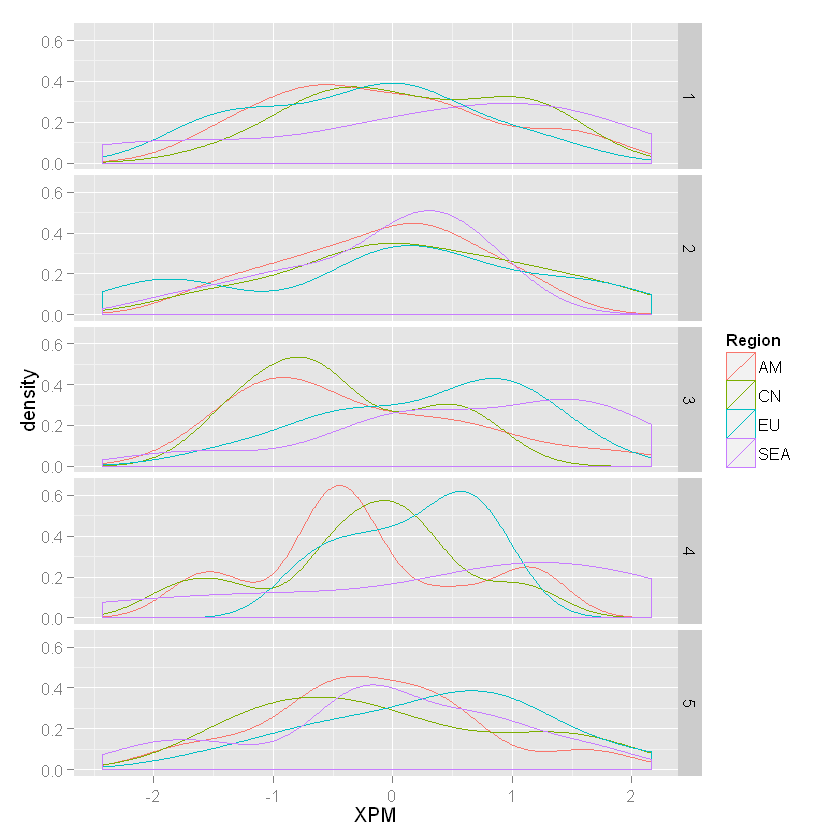

In [14]:
# Density plot to see exp distribution between regions and positions
g <- ggplot(data = scaled_frankfurt, aes(x = XPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

XPM plots are a little all over the place and it is very difficult to make anything out of this. The only consistent thing that shows is that EU players seem to get more XP in this tournament. OG and Secret were the winner and runner-up for this tournament so maybe their XP gained skewed the results towards EU.

The previous analysis included all teams, including the ones who participated in qualifiers but not in the main event. We are more interested in the ones that participated in main event so let's subset and see.

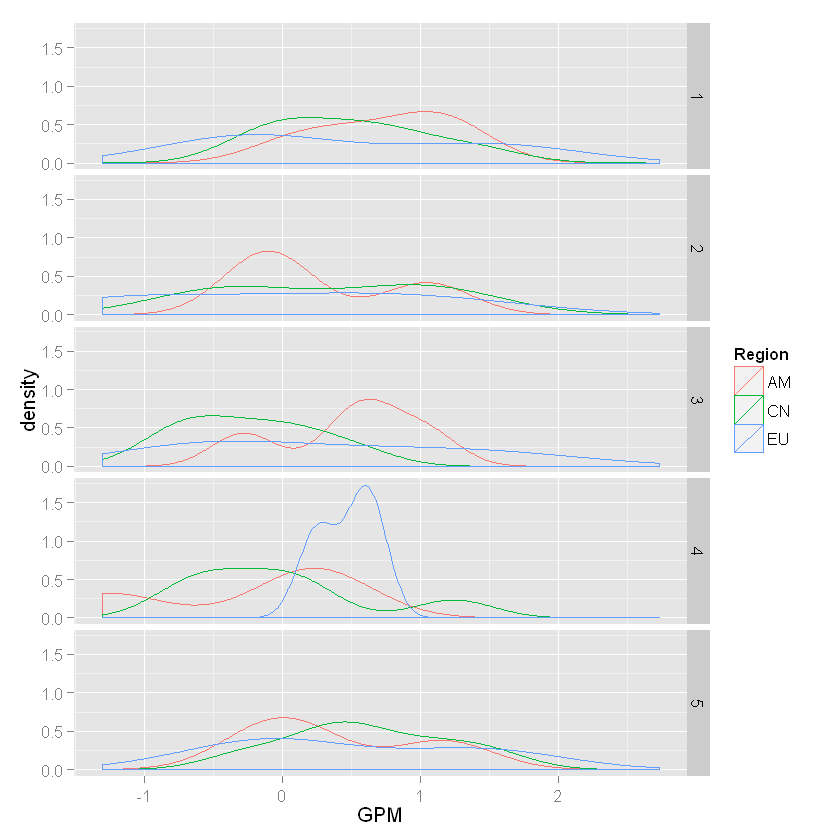

In [15]:
# Subset the data so that we retain only the teams that participated in the main event
main_event_frankfurt <- scaled_frankfurt[frankfurt$Tournament_Result > 0,]
# Density plot to see farm distribution between regions and positions
g <- ggplot(data = main_event_frankfurt, aes(x = GPM, color = Region))
g + geom_density()  + facet_grid(Position ~.)

After subsetting, there was only one SEA team left, and there is no density function defined for a single data point so we don't see SEA in this plot.

One thing that is really interesting in this plot is that, the GPM distribution of EU teams in the main event were generally right-skewed. This means their GPM was generally on the lower side.

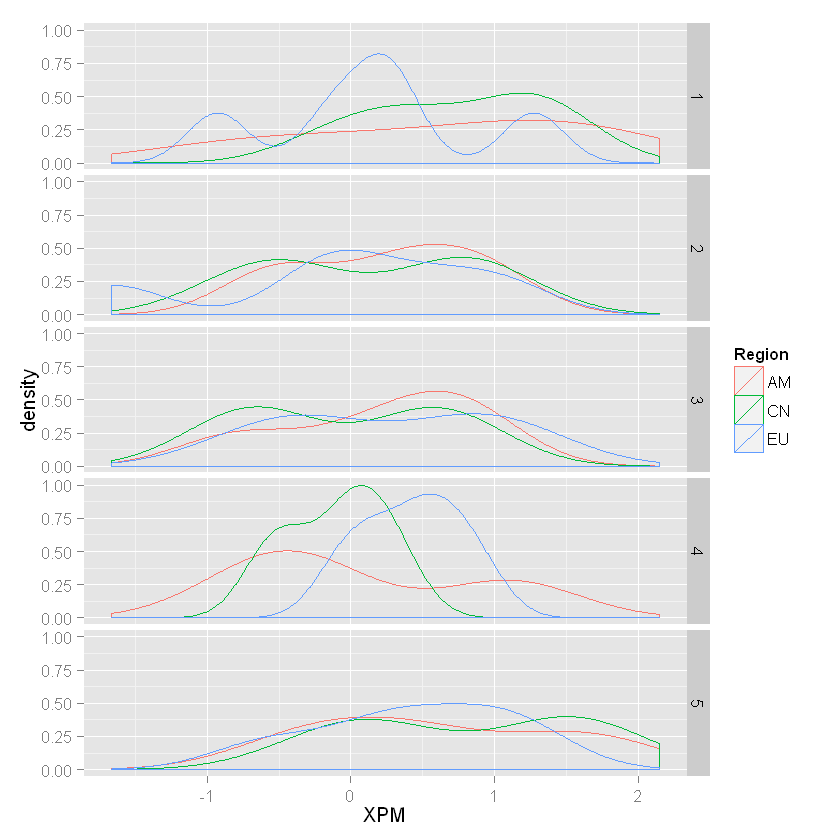

In [16]:
# Density plot to see exp distribution between regions and positions
g <- ggplot(data = main_event_frankfurt, aes(x = XPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

One thing to consider is that, when we remove the qualifier teams, the data points become significantly fewer. This means that while these two plots show some interesting stuff, the information they relay is not reliable. Let's see if there's a difference in farm between qualified and non-qualified teams.

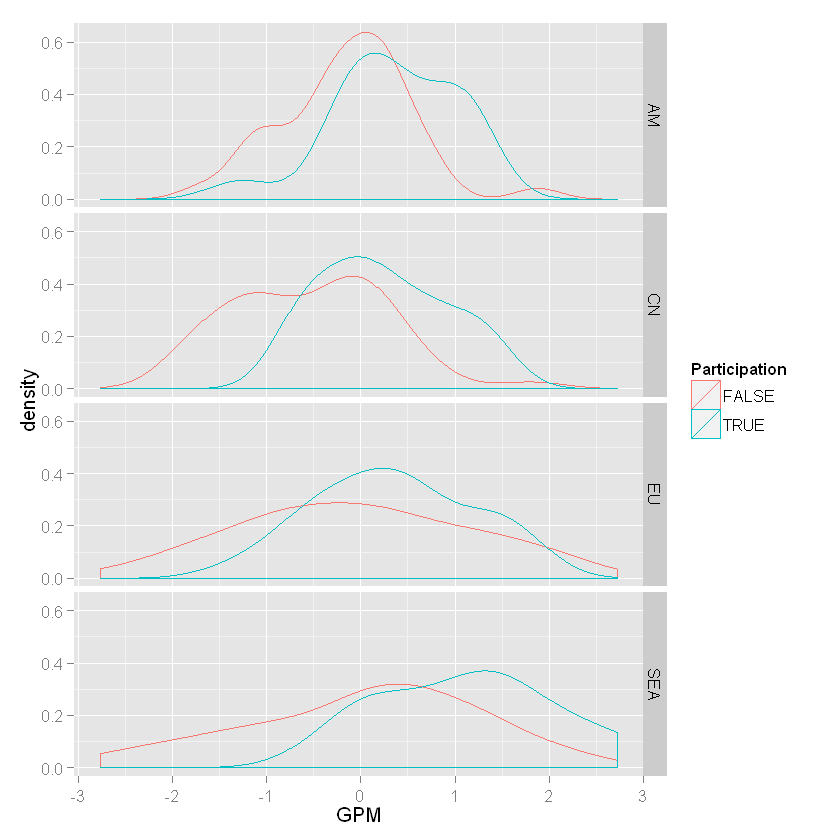

In [17]:
# Let's see how GPM differs between teams that participated in the main event and the teams that hadnt
scaled_frankfurt2 <- scaled_frankfurt
scaled_frankfurt2$Participation <- scaled_frankfurt$Tournament_Result>0
g <- ggplot(data = scaled_frankfurt2, aes(x = GPM, color = Participation))
g + geom_density() + facet_grid(Region ~.)

Now THAT shows a clear pattern. It tells us that consistently and in all regions, teams that qualified for main event had more GPM. This probably shows that teams that qualified are more efficient in using map for farm. It probably also means that they won the team-fights and ultimately the games, knocking out the other teams.

Note that these plots can be interpreted in different ways. The first thing that most people think initially is "More GPM leads to better results in the tournament." which might be true or not. It might also be the case that the teams that qualified were simply better which made them qualify and their GPM was just a by-product of how good they are.

Bottom line is, the fact that there is a clear pattern doesn't mean there is a causal relationship. Be careful with your causality claims, they are usually wrong.

So far we only used Frankfurt Major data, but we have more tournaments. Let's use their data for a more complete view.

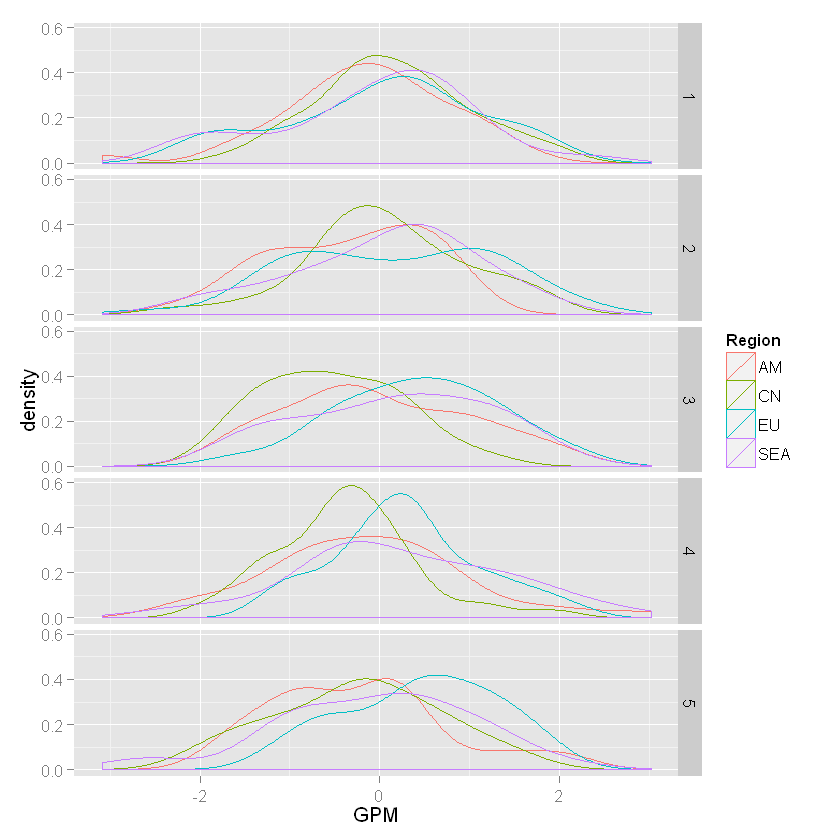

In [18]:
# Let's do the same thing for shanghai and manila and then combine them together for a more complete view
scaled_shanghai <- fix_dataframes(shanghai)
scaled_manila <- fix_dataframes(manila)

scaled_tournaments <- rbind(scaled_frankfurt[,1:18], scaled_shanghai[,1:18], scaled_manila)
# Density plot to see farm distribution between regions and positions
g <- ggplot(data = scaled_tournaments, aes(x = GPM, color = Region))
g + geom_density()  + facet_grid(Position ~.)

This plot kind of shows that EU gets more farm. Again, without having domain expertise there is no way to know the reason for this but some of the reasons might be as follows:
- EU teams won more games
- EU playstyle is more farm oriented
- EU likes to play heroes that farm more easily
etc. etc.

Since I am terrible at this game, I can't come up with any more reasons. But someone who is good can probably tell you why that pattern shows up.

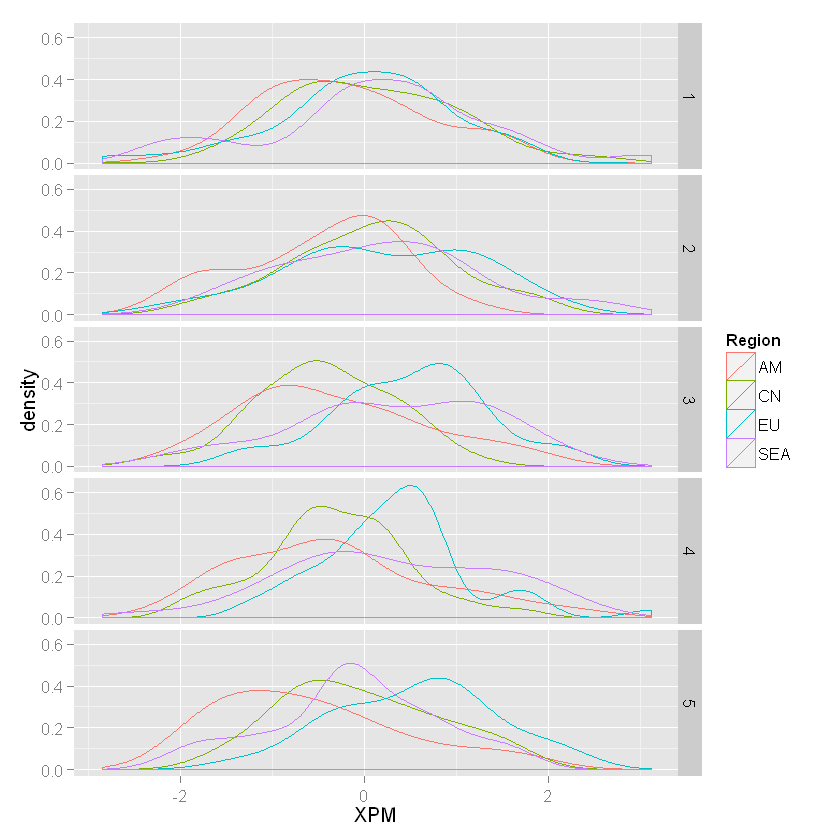

In [19]:
# Density plot to see exp distribution between regions and positions
g <- ggplot(data = scaled_tournaments, aes(x = XPM, color = Region))
g + geom_density() + facet_grid(Position ~.)

Let's once more look into the difference between teams that qualified for the main events and the teams that didn't.

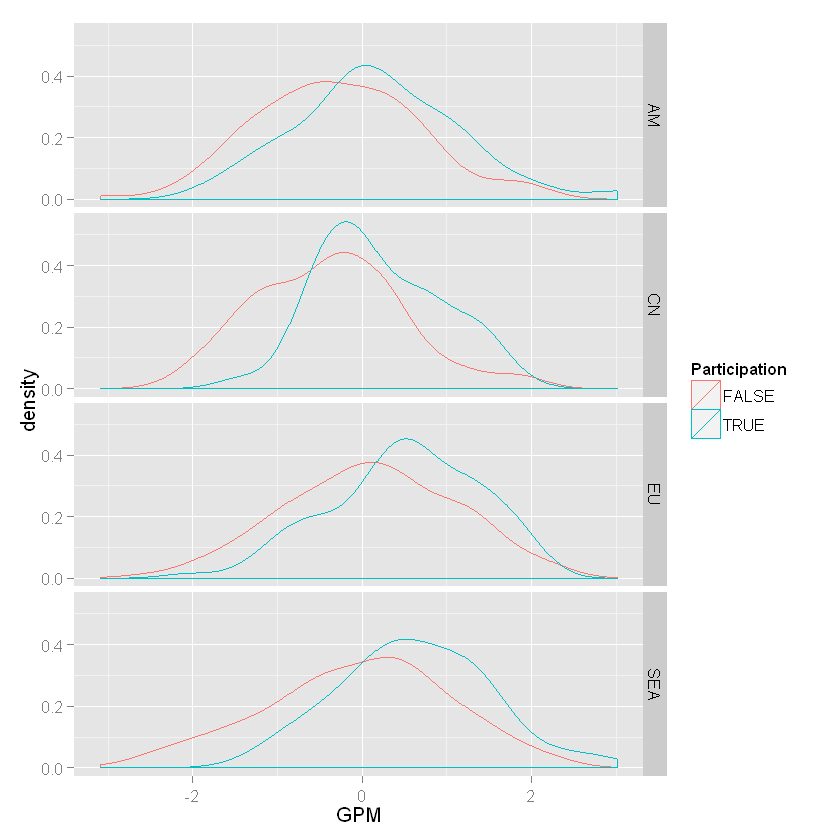

In [20]:
# Let's see how GPM differs between teams that participated in the main event and the teams that hadnt
scaled_tournaments2 <- scaled_tournaments
scaled_tournaments2$Participation <- scaled_tournaments$Tournament_Result>0
g <- ggplot(data = scaled_tournaments2, aes(x = GPM, color = Participation))
g + geom_density() + facet_grid(Region ~.)

There is again a clear difference between the teams that participated in the main event and the teams that didn't. Participant teams just got more farm.

Now density plots are great for seeing the behavior of features on their own, but we are also interested in relationships between two variables. To observe those relationships we need to use scatterplots. Let's see if there is a relationship between XPM and GPM.

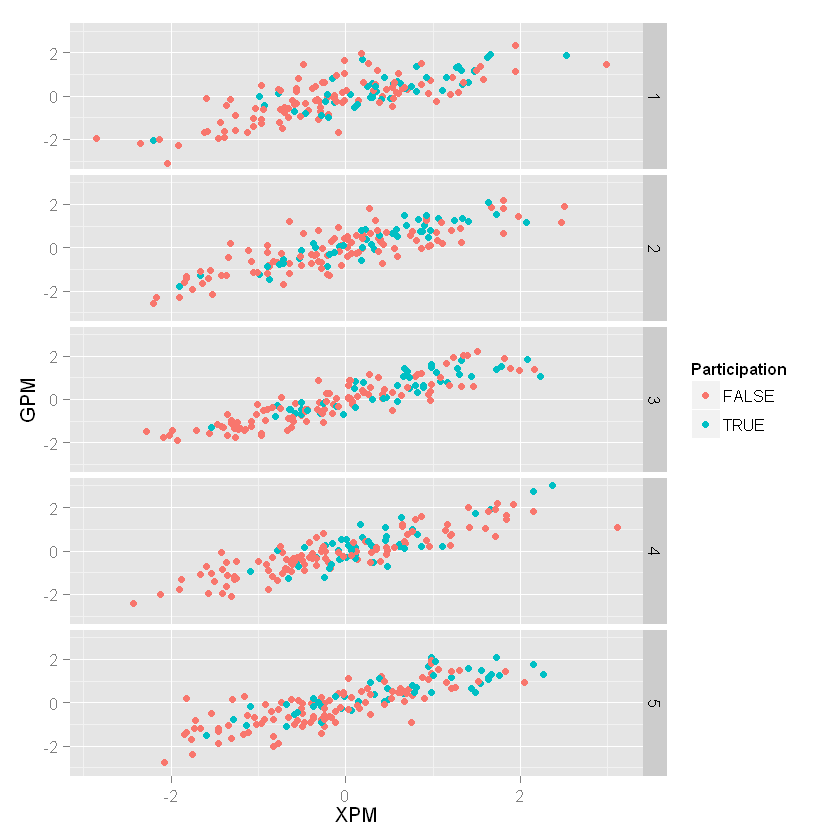

In [21]:
# Scatterplot
# To observe the dual relatipnship between variables
g <- ggplot(data = scaled_tournaments2, aes(x = XPM, y= GPM, color = Participation))
g + geom_point() + facet_grid(Position ~.)

This plot is kind of complex so let's break it down. It shows us whether there is a relationship between XPM and GPM as well as information regarding the effect of the player position and main event participation.

Since we are using scaled data, we don't see any difference between player positions in terms of XPM vs. GPM distribution. We scaled to remove that effect specifically so that makes sense. There is a slight pattern regarding participation, the teams that participated in the main event tend to have slightly higher GPM and XPM it seems. Bu again, we had seen this before so this isn't new information.

The new information we have is the linear nature of the relationship between XPM and GPM. If you are familiar with Dota 2, this is expected because XP and Gold resources are actually (almost) the same in the game which means whenever you are getting gold, you are (almost always) getting XP. However, the amounts you get aren't exact so there is some deviation in the scatterplot.

So let's see the same plot without scaling.

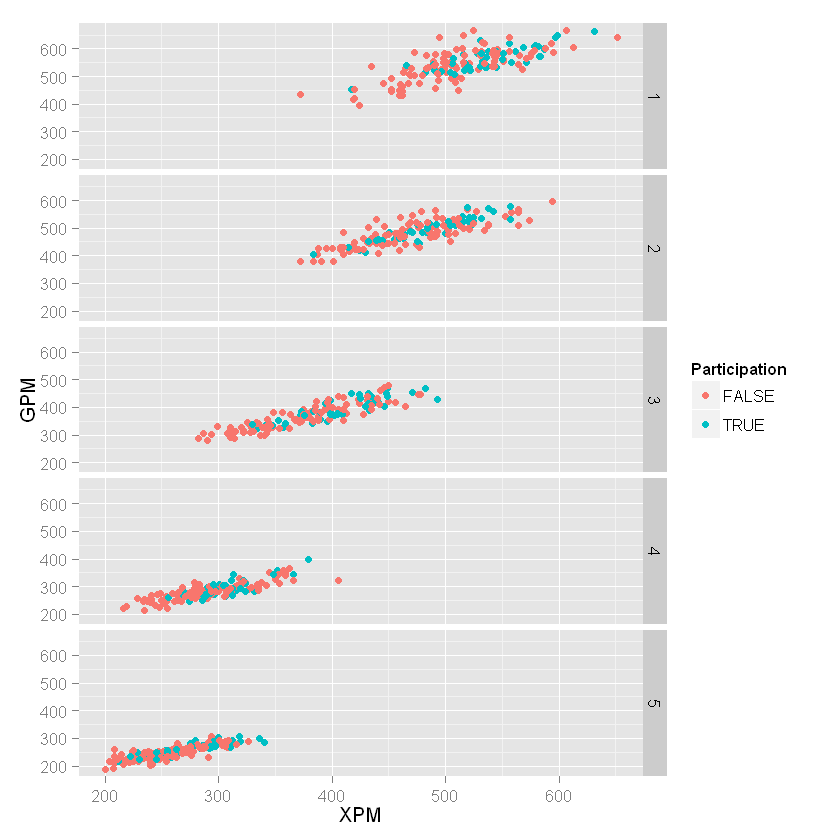

In [22]:
# What if we hadn't scaled?
tournaments <- rbind(frankfurt[,1:18], shanghai[,1:18], manila)
tournaments2 <- tournaments
tournaments2$Participation <- tournaments$Tournament_Result>0
g <- ggplot(data = tournaments2, aes(x = XPM, y= GPM, color = Participation))
g + geom_point() + facet_grid(Position ~.)

Now we see the effect of positions. There is some overlap between positions but there is a very clear pattern. Position 1 gets most gold and XP while pos 5 gets least. Again, this is how positons are determined so no surprises there. One thing that this plot does is to emphasize the value of scaling (when appropriate ofc.). This plot is really ugly, so much empty space :/

Now we have analyzed the relationship of two variables but we have many more! Should we do binary combinations of all variables we have to see if there is a relationship? Sometimes you should, yes. But in our case, to cut this notebook short, I will simply look at a correlogram which plots the binary correlations between numeric variables.

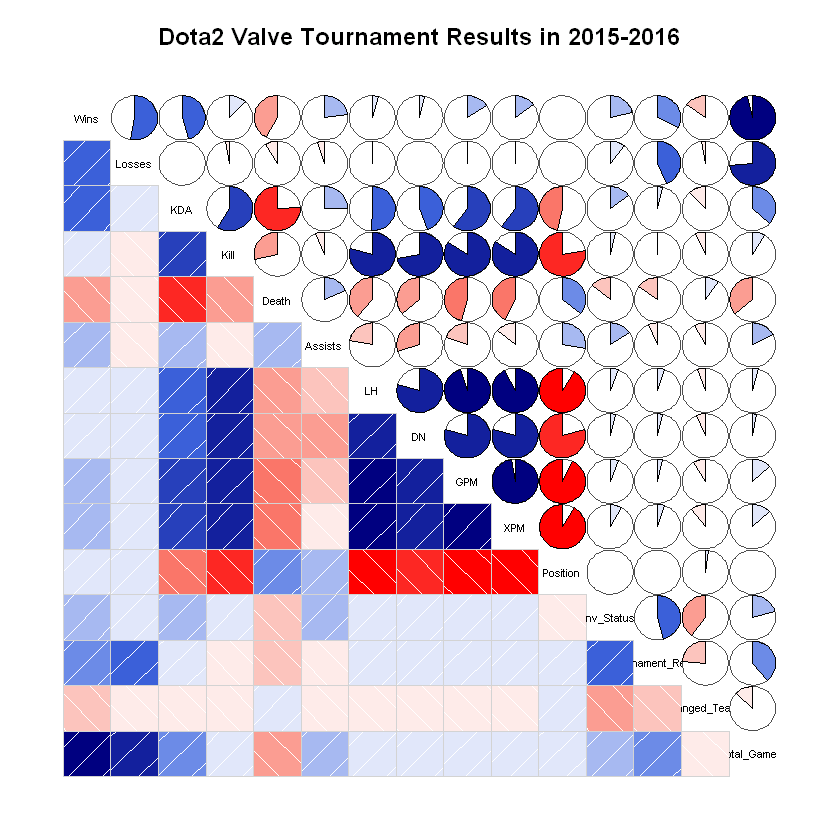

In [23]:
# Correlation
numeric_vars <- which(sapply(tournaments, is.numeric))
pc <- cor(tournaments[,numeric_vars])
corrgram(tournaments[,numeric_vars], order = FALSE, lower.panel=panel.shade,
         upper.panel=panel.pie, text.panel=panel.txt,
         main="Dota2 Valve Tournament Results in 2015-2016")

Now this plot is kind of difficult to read. I will explain this during the meetup so don't worry about it now. (I will also edit this after the meetup)

## Modeling, Validation and Prediction
One thing that is great about using R is that there is a library called "caret" which means that you can combine these together. Let's model and predict the placement a player would get in an unseen tournament.

First we separate a test set from our data so that we can predict unseen data later.
We also need to remove some features because they increase cardinality of our data too much.
Later we need to determine the validation procedure of our modelling process so we don't overfit. We have a few options here. I discussed this in the presentation so I won't go into detail here.

In [28]:
# We don't want the Player and Team information because those are unique values and they will cause overfitting.
tournaments$Tournament_Result <- as.factor(tournaments$Tournament_Result)
set.seed(1599)
train_indexes <- createDataPartition(tournaments$Tournament_Result, p = .75, list = F)
train_data <- tournaments[train_indexes, -c(1,2)]
test_data <- tournaments[-train_indexes, -c(1,2)]
fitControl <- trainControl(method = 'repeatedcv',
                           number = 3,
                           repeats = 3)

model1 <- train(Tournament_Result~. ,
                data = train_data,
                method = 'gbm',
                trControl = fitControl,
                verbose = F)
model1

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        2.8332             nan     0.1000    1.4178
     2        1.9565             nan     0.1000    0.4798
     3        1.6702             nan     0.1000    0.2967
     4        1.4869             nan     0.1000    0.2253
     5        1.3470             nan     0.1000    0.1577
     6        1.2405             nan     0.1000    0.1056
     7        1.1584             nan     0.1000    0.0935
     8        1.0835             nan     0.1000    0.0835
     9        1.0192             nan     0.1000    0.0511
    10        0.9683             nan     0.1000    0.0520
    20        0.6500             nan     0.1000   -0.0025
    40        0.3840             nan     0.1000   -0.0042
    60        0.2575             nan     0.1000   -0.0148
    80        0.1736             nan     0.1000   -0.0078
   100        0.1230             nan     0.1000   -0.0076
   120        0.0909             nan     0.1000   -0.0053
   140        

Stochastic Gradient Boosting 

568 samples
 15 predictor
 17 classes: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 3 times) 

Summary of sample sizes: 379, 378, 379, 379, 378, 379, ... 

Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa      Accuracy SD  Kappa SD  
  1                   50      0.8022185  0.6132002  0.01828684   0.04020724
  1                  100      0.8339058  0.6872781  0.02505918   0.04775550
  1                  150      0.8397692  0.6996362  0.01791349   0.03190855
  2                   50      0.8309508  0.6835080  0.02691831   0.05093065
  2                  100      0.8385841  0.6992114  0.02156968   0.03976692
  2                  150      0.8415267  0.7044861  0.01673497   0.03090544
  3                   50      0.8350877  0.6933065  0.01691692   0.03202290
  3                  100      0.8427179  0.7059

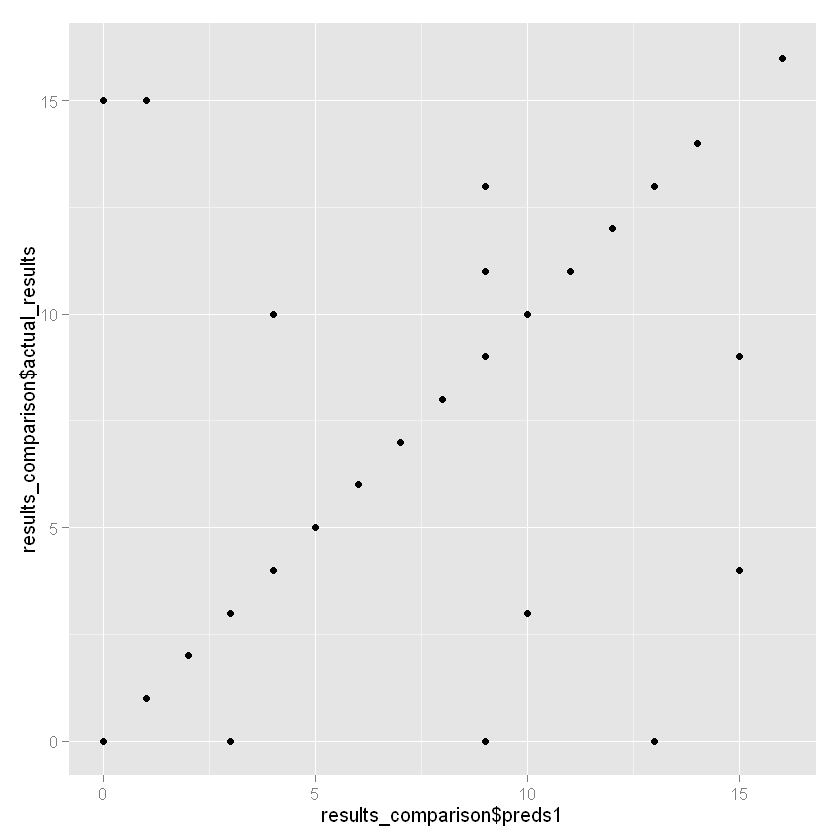

In [31]:
# Prediction
preds1 <- predict(model1, test_data[,-14])
actual_results <- test_data$Tournament_Result
results_comparison <- data.frame(actual_results, preds1)
results_comparison$actual_results <- as.integer(results_comparison$actual_results)-1
results_comparison$preds1 <- as.integer(results_comparison$preds1)-1
qplot(results_comparison$preds1, results_comparison$actual_results)

player_team_names_test <- tournaments[-train_indexes, 1:2]
results_comparison <- data.frame(results_comparison,player_team_names_test)

Discussion: How did we do? Is this a good model? (Hint: Data leakage)

## Second Model (Predict Invitations)
Let's predict invites for the Manila major based on player's performance at previous Valve events, namely Frankfurt and Shanghai Majors.

So what I did was, I generated a classification model that takes previous performance as input and predicts whether the given player has been invited or not for the Manila Major. The "invite" has 4 levels. First level (1) is no participation whatsoever in the event. The second level (2) means no invite but the player participated in the open qualifiers. Third level (3) means that the player was invited to the regional qualifiers. Final level (4) means that the player's team got a direct invite to the main event.

I trained the model, predicted player invitations and then I aggregated the player invitation predictions to obtain team invitation results.

One thing to keep in mind is that, while the training set has level-1, the test set (which is the manila dataset) does not have this level at all because it only holds data for teams/players that participated in some stage of manila major. This skews the results as seen in confusion matrix. More on that after we obtain results.

In this section, on top of the classification model we built above, I added a grid search component to perform parameter selection in the form of grid search.

In [62]:
# Invite prediction
train_invite <- rbind(scaled_frankfurt, scaled_shanghai)
test_invite <- scaled_manila
train_invite$Outcome <- as.factor(train_invite$Outcome)

gbmGrid <-  expand.grid(n.trees = (1:4)*50,
                        interaction.depth = c(1, 5, 9),
                        shrinkage = c(0.01, 0.1, 0.2))
set.seed(3)
model2 <- train(Outcome~.,
                data = train_invite[,-c(1:2, 14)],
                method = "gbm",
                trControl = fitControl,
                verbose = F,
                tuneGrid = gbmGrid)
model2

Stochastic Gradient Boosting 

481 samples
 15 predictor
  4 classes: '-1', '0', '1', '2' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 3 times) 

Summary of sample sizes: 320, 321, 321, 321, 320, 321, ... 

Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa      Accuracy SD
  0.01       1                   50      0.6056642  0.4087210  0.02734610 
  0.01       1                  100      0.6007897  0.3957863  0.03135870 
  0.01       1                  150      0.6070832  0.4049669  0.02577662 
  0.01       1                  200      0.6049912  0.4011332  0.01989256 
  0.01       5                   50      0.6201914  0.4242580  0.03067445 
  0.01       5                  100      0.6216020  0.4265092  0.03070152 
  0.01       5                  150      0.6195489  0.4232232  0.02924903 
  0.01       5                  200      0.6146834  0.4158019  0.02909394 
  0.01       9                   50      0.6215588 

In [64]:
# Predict
preds2 <- predict(model2, test_invite[,-c(1:2, 14)])
actual_results_inv <- factor(test_invite$Inv_Status, levels = levels(preds2))
test_invite$TrueOutcome <- as.integer(actual_results_inv)
test_invite$PredictedOutcome <- as.integer(preds2)

# Aggregate for team invitations (take average)
team_invite_true <- aggregate(test_invite[, 19], list(test_invite$Team), mean)
team_invite_predicted <- aggregate(test_invite[, 20], list(test_invite$Team), mean)
team_invite_predicted$x <- as.integer(round(team_invite_predicted$x))
team_invite_true <- team_invite_true$x
team_invite_predicted <- team_invite_predicted$x

# Change to factor to calculate confusion matrix
team_invite_predicted <- factor(team_invite_predicted, levels = c("1","2","3","4"))
confusionMatrix(team_invite_predicted,
                factor(team_invite_true, levels = levels(team_invite_predicted)))

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1  0  4  8  0
         2  0  2  5  1
         3  0  4 16  5
         4  0  0  1  6

Overall Statistics
                                          
               Accuracy : 0.4615          
                 95% CI : (0.3223, 0.6053)
    No Information Rate : 0.5769          
    P-Value [Acc > NIR] : 0.9652          
                                          
                  Kappa : 0.1866          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity                NA  0.20000   0.5333   0.5000
Specificity            0.7692  0.85714   0.5909   0.9750
Pos Pred Value             NA  0.25000   0.6400   0.8571
Neg Pred Value             NA  0.81818   0.4815   0.8667
Prevalence             0.0000  0.19231   0.5769   0.2308
Detection Rate         0.0000  0.03846   0.3077   0.1154
Detection Prevalence   0.2308  0.15385   0.480

As I mentioned above, there is no level 1 data in the reference results. This reduces our accuracy significantly. What we are interested in is actually the performance on level 4 and we also some interedt in level 3. 

On level-4, we have 50% accuracy. Of 12 teams that were invited to the main event, we were able to predict that 6 teams would be invited as such. Of these 12 teams, we predicted 5 would be invited to the regional qualifiers instead. One thing to keep in mind is that Valve did something different in Manila Major, previously they used to invite 8 teams to main event. This time they invited 12 teams because they couldn't decide. 

On level-3 we have 53.33% accuracy, out of 30 teams that were asked to participate in regional quals we predicted 16 would be invited as such. Oddly enough, we predicted one team should have been invited directly to main event. We also predicted 8 teams shouldn't have participated at all. The one team that should have been invited to the main event directly comes up as Newbee (which kind of makes sense, considering they placed 3rd at that event).

### Conclusion
This model is far from perfect. It doesn't perform as well as I'd like it to. However, the results show promise because this model includes only Valve events. If we included 3rd party tournaments, the accuracy might increase. Also, even in the case of errors, the errors make sense. For instance, the model confused half of the direct invites as regional qualifier participants but the classes are adjacent to each other. It didn't randomly classify those 5 teams as different classes. This suggests that with improvement, we might actually have a system that will accurately predict invitations. It was also smarter than Valve in Newbee's case as IMO Newbee should have been a direct invite.

This notebook shows different steps of data science process. As you can see, even though notebook has ended, data science process hasn't. We have a promising model that needs to be worked upon. And the things we have done so far need to be re-done several times to have an acceptable model. In its current state, this model actually sucks. If you improve it, let me know, I'd like to see what you come up with.

## Contact
Ayse Elvan Aydemir

E-mails: 
- agunduz@metu.edu.tr
- aelvan@nornanalytics.com
- elvan@teamsecret.gg